In [2]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K

from MD_AE_model import *
import myplot
import mode_decomposition as md

import h5py
import numpy as np
import matplotlib.pyplot as plt

## import data
folder = '/home/ym917/OneDrive/PhD/Code_md-ae/Hierarchical_10_1__2022_04_12__15_54_24/'
filename = folder + 'results.h5'
hf = h5py.File(filename,'r')
u_test = np.array(hf.get('u_test'))
hist_train = np.array(hf.get('hist_train'))
hist_val = np.array(hf.get('hist_val'))
u_avg = np.array(hf.get('u_avg'))
latent_test = np.array(hf.get('latent_test')) # shape [latent_variable, test_snapshots, 1]
y_test = np.array(hf.get('y_test')) # [modes,nt,ny,nz,nu]
hf.close()

latent_test = np.squeeze(latent_test).T # shape [snapshots, latent_variable]

filename = folder + 'Model_param.h5'
hf = h5py.File(filename,'r')
Ny = int(hf.get('Ny')[()])
Nz = int(hf.get('Nz')[()])
Nu = int(hf.get('Nu')[()])
features_layers = np.array(hf.get('features_layers')).tolist()
no_of_modes = int(hf.get('no_of_modes')[()])
latent_dim = int(hf.get('latent_dim')[()])
resize_meth = hf.get('resize_meth')[()].decode()
filter_window = np.array(hf.get('filter_window')).tolist()
act_fct = hf.get('act_fct')[()].decode()
batch_norm = hf.get('batch_norm')[()]
drop_rate = hf.get('drop_rate')[()]
lmb = hf.get('lmb')[()]
idx_unshuffle = np.array(hf.get('idx_unshuffle'))
hf.close()

In [4]:
## load models
Nx = [Ny,Nz]
previous_dim = []
subnets = []
for _ in range(no_of_modes):
    subnets.extend([hierarchicalAE_sub(Nx=Nx,Nu=Nu,previous_dim=previous_dim,features_layers=features_layers,latent_dim=latent_dim,filter_window=filter_window,act_fct=act_fct,drop_rate=drop_rate,lmb=lmb)])
    previous_dim.extend([latent_dim])



load_which = [0,1,2,3,4,5,6,7,8,9] # start from 0
inn = [u_test]
for net in load_which:
    subnets[net].predict(inn)
    weights = folder + 'subnet' + str(net+1) + '.h5'
    subnets[net].load_weights(weights)
    inn.append(subnets[net].encoder.predict(u_test))

In [20]:
mode_single = []
for i in range(no_of_modes):
    a = np.zeros((10,10))
    a[i,i] = 1
    latent_single = latent_test @ a
    mode_single.append(subnets[no_of_modes-1].decoder.predict(latent_single))
mode_single = np.array(mode_single)

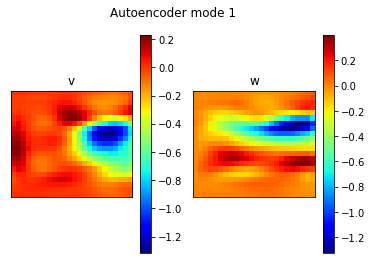

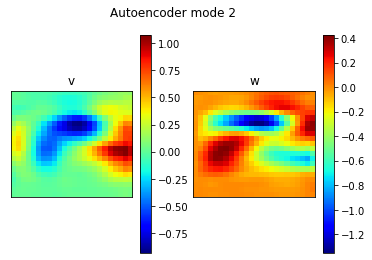

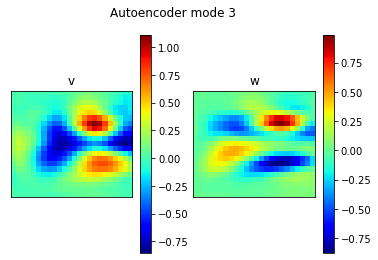

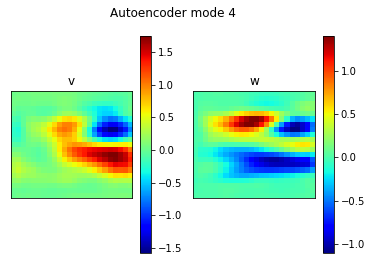

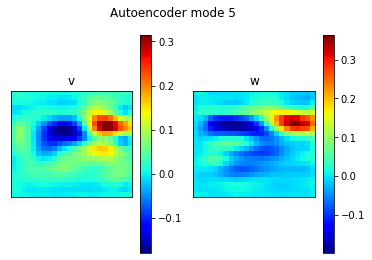

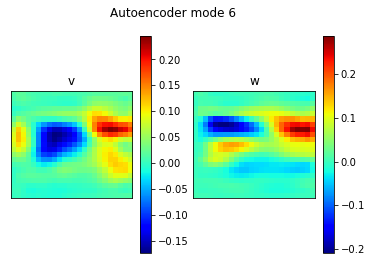

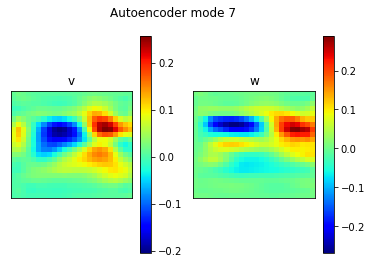

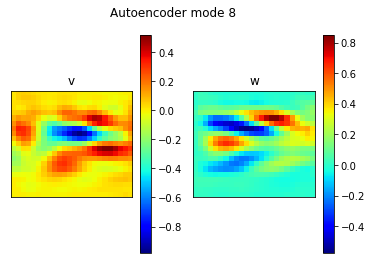

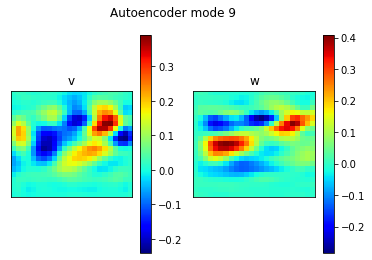

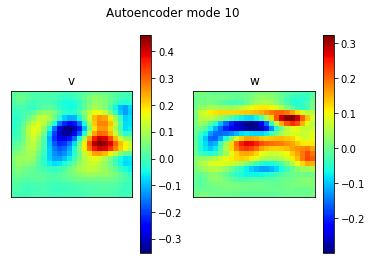

In [22]:
myplot.plot_ae_modes(mode_single,range(10),snapshot=0)